## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

# Data Exploration

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


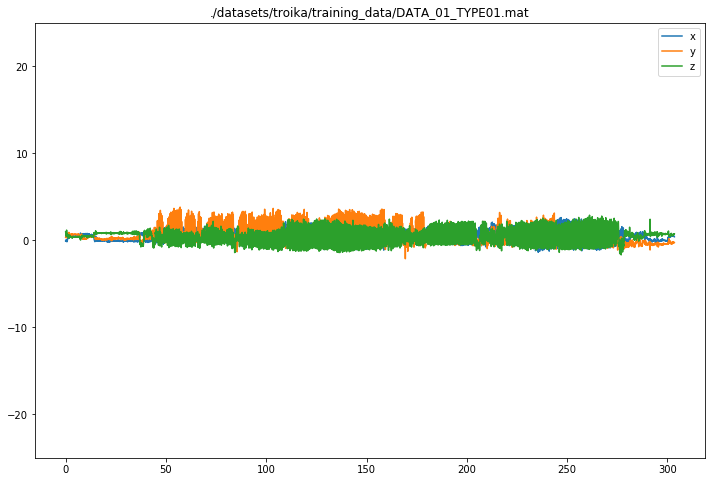

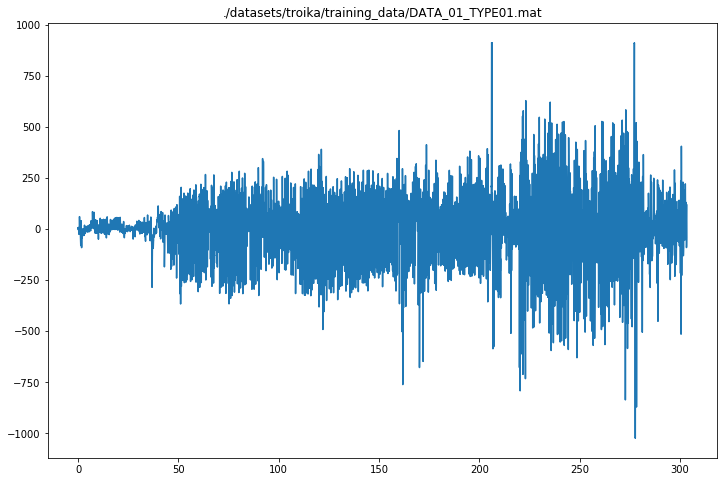

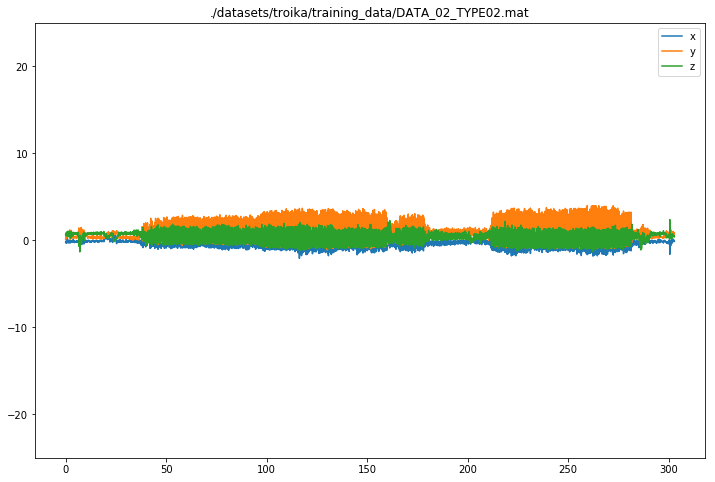

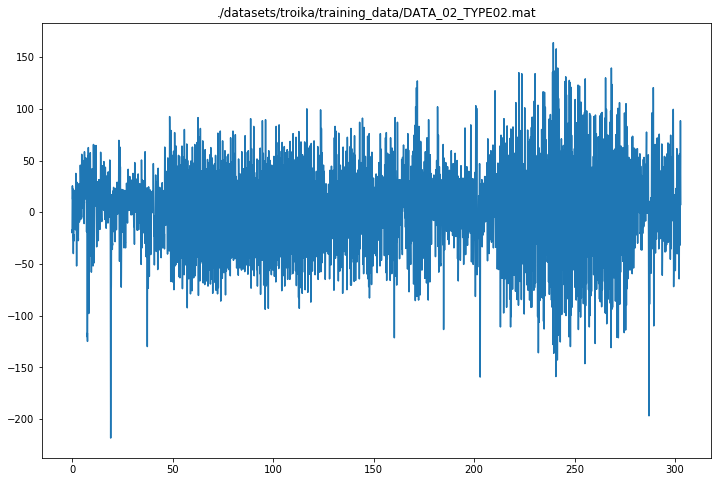

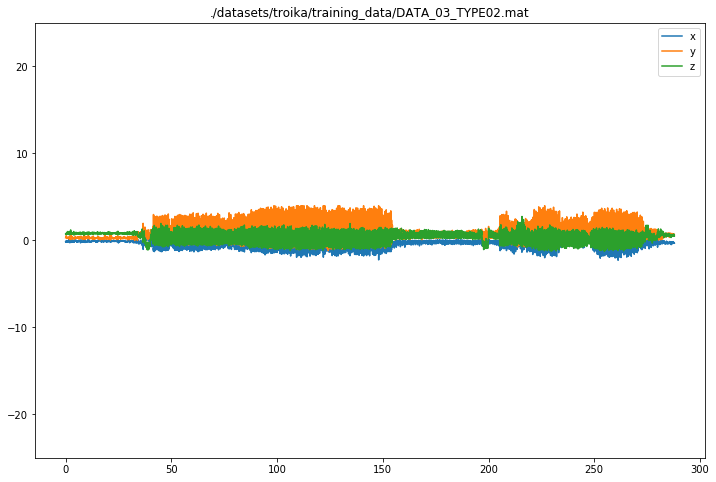

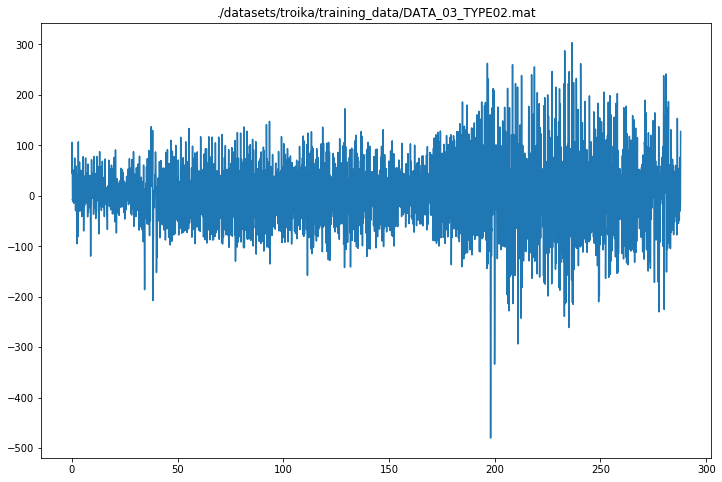

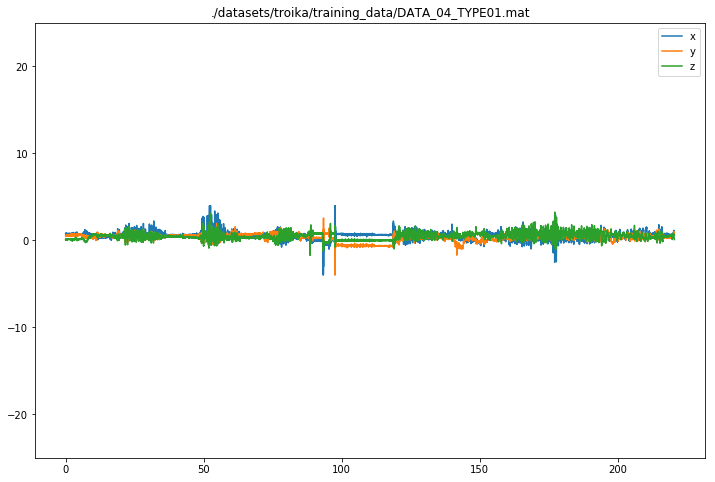

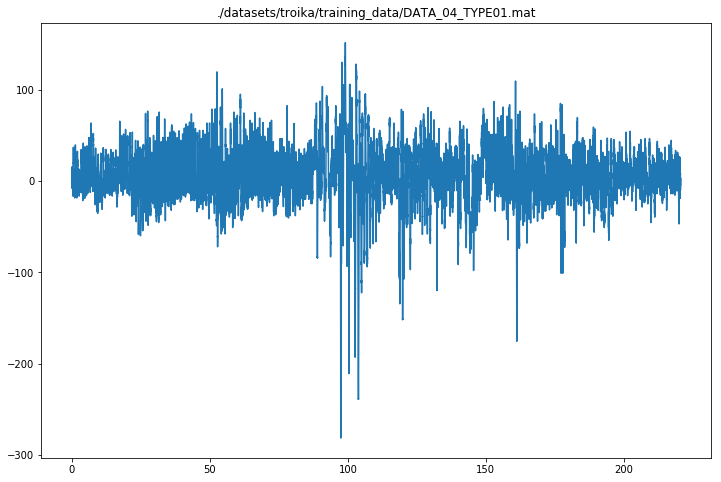

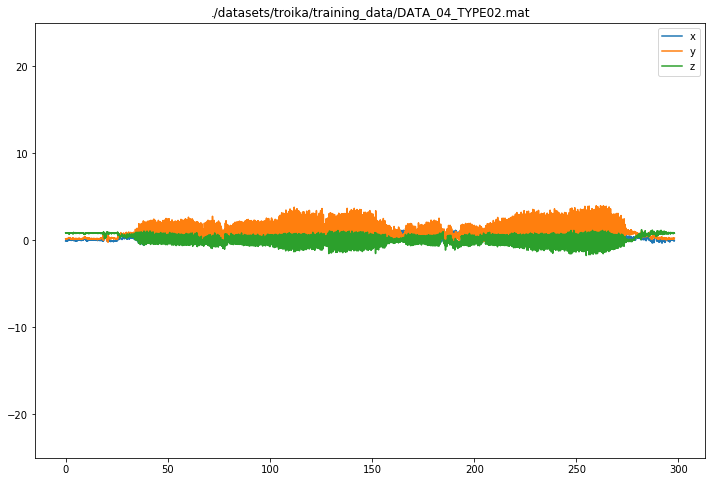

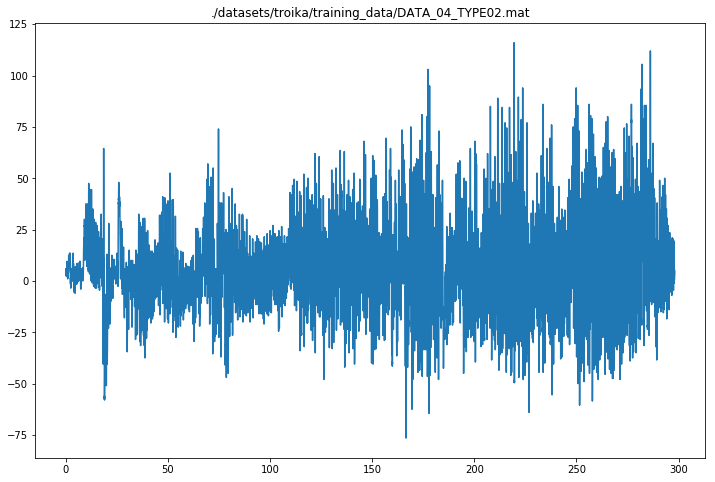

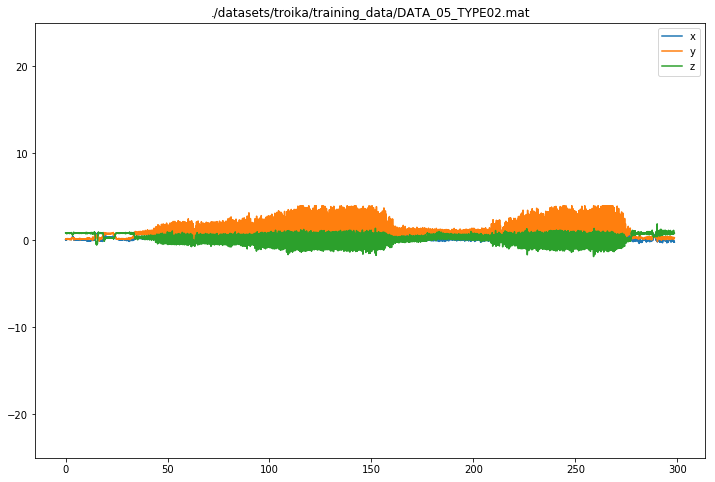

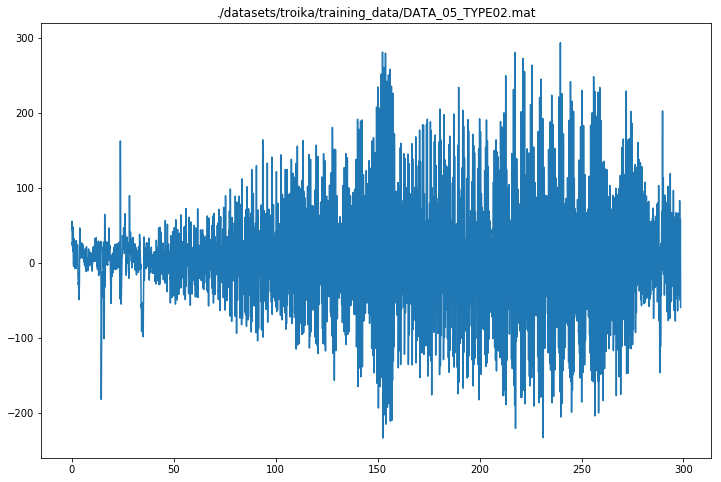

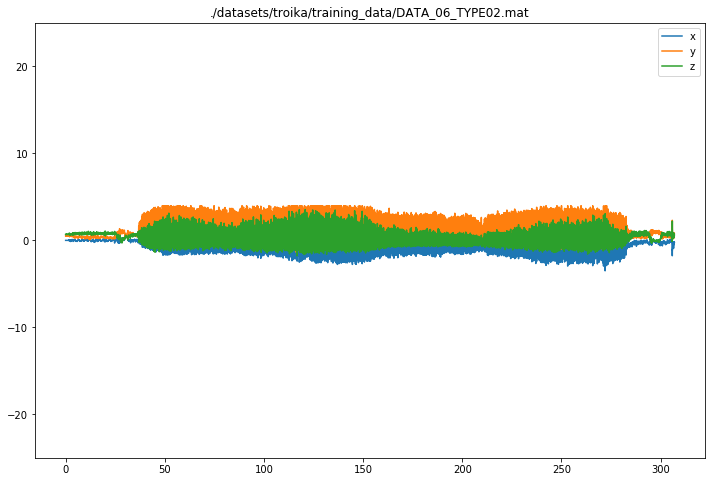

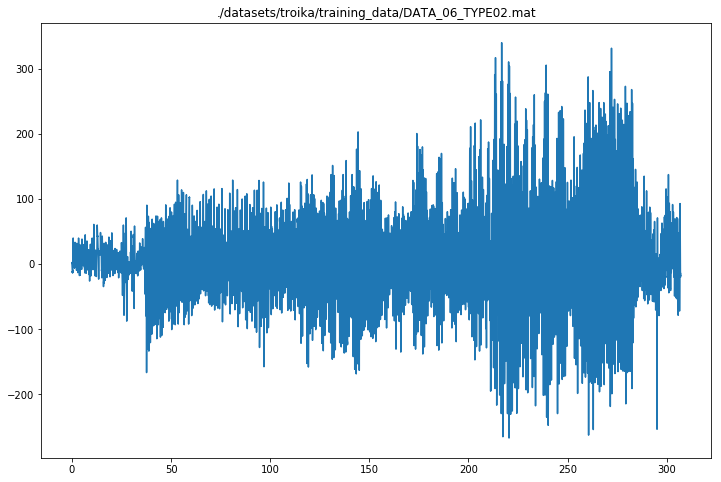

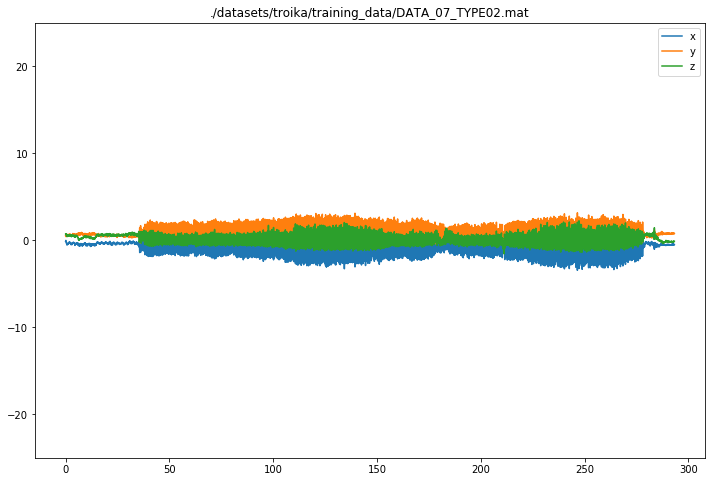

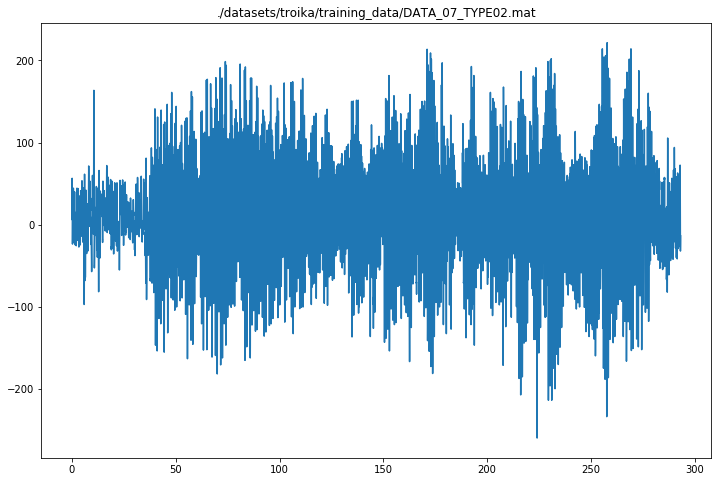

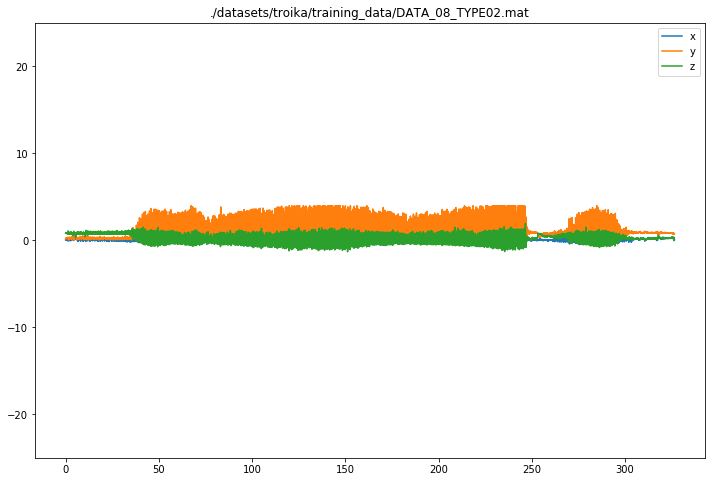

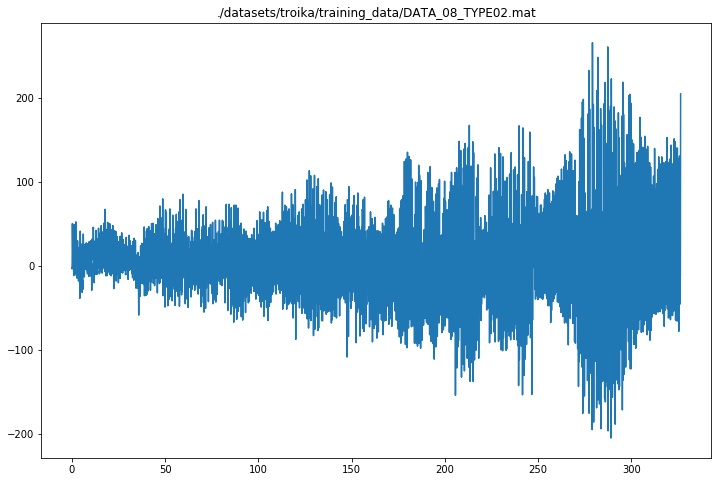

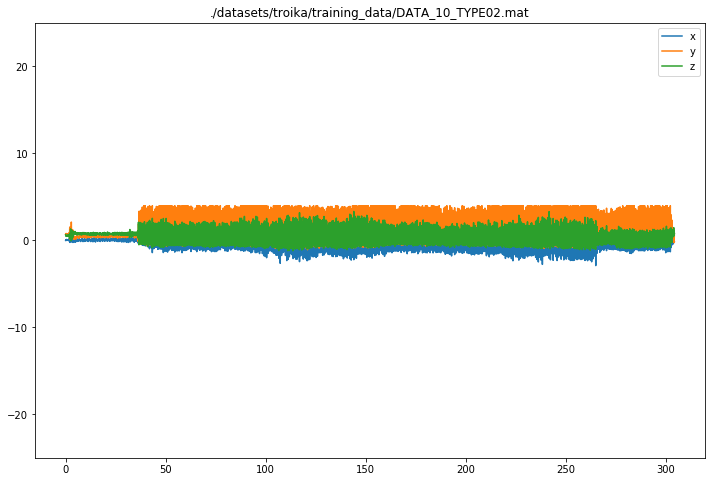

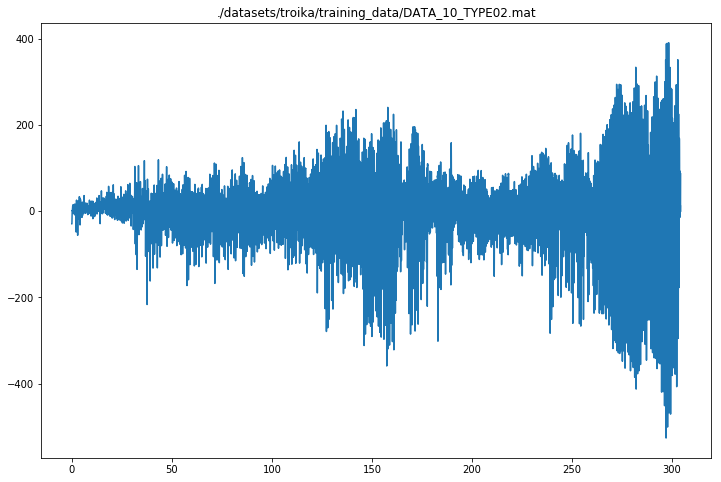

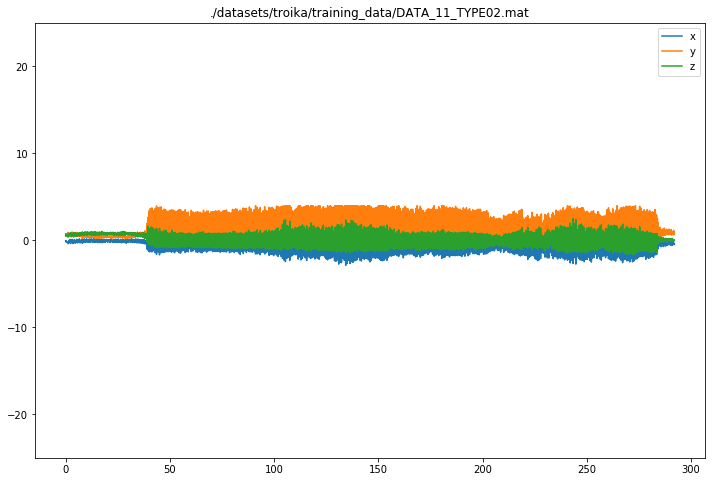

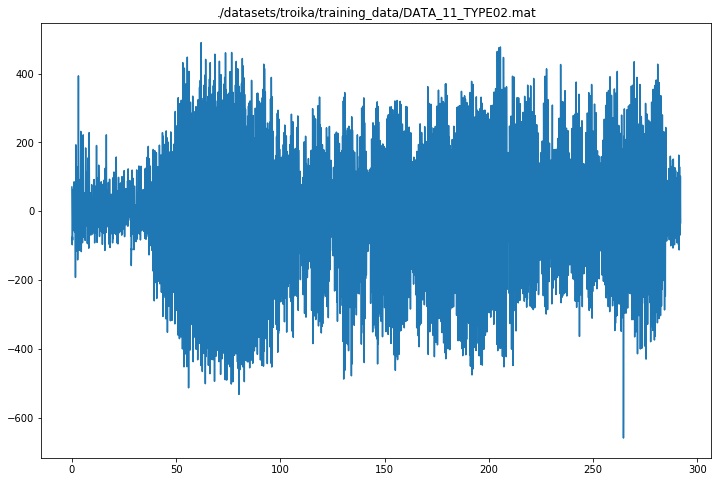

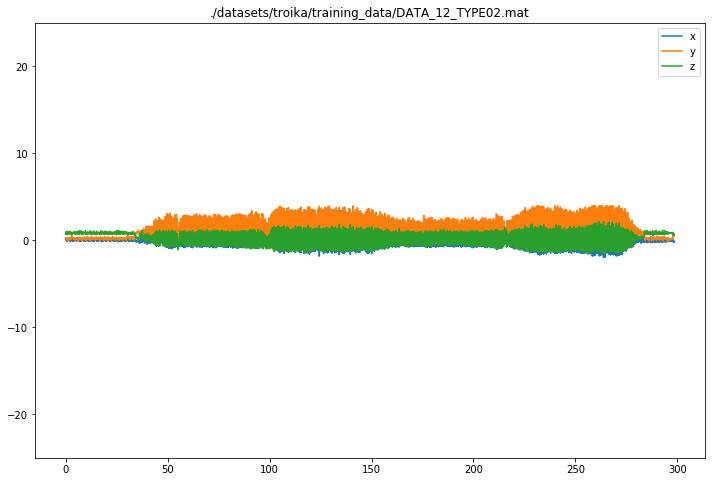

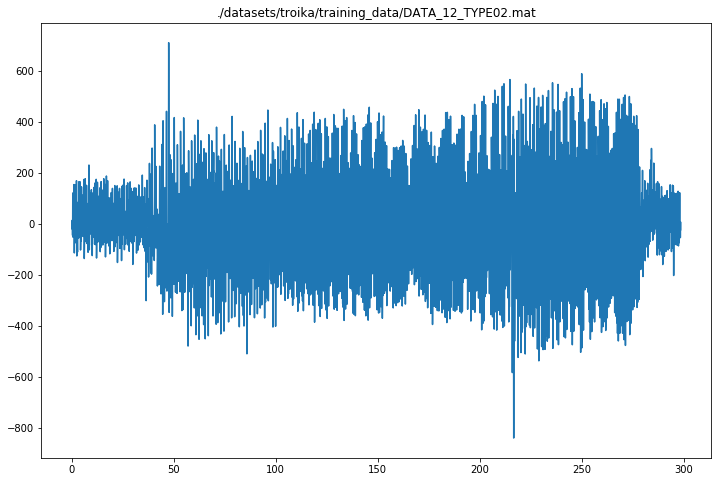

In [31]:
fs=125
data_fls, ref_fls = LoadTroikaDataset()

for i in range(len(data_fls)):
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[i])
    ts = np.arange(len(accx)) / fs
    plt.figure(figsize=(12, 8))
    plt.plot(ts, accx, label='x')
    plt.plot(ts, accy, label='y')
    plt.plot(ts, accz, label='z')
    plt.title(data_fls[i])
    plt.legend()
    plt.ylim((-25, 25))
    plt.draw() 
    
    plt.figure(figsize=(12, 8))
    plt.plot(ts, ppg)
    plt.title(data_fls[i])
    plt.draw()

### Code

In [3]:
import glob

import numpy as np
import scipy as sp
from scipy import signal
import scipy.io
from matplotlib import pyplot as plt
from matplotlib import mlab

fs=125 #sampling rate
minfreq=0.66 #40 bpm
maxfreq=4 #240
    
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def BandpassFilter(sig, pass_band, fs):
    """Bandpass Filter.
    Adapted from Lesson 2, Excercise 4
    Args: ,sig (variable name), pass_band: (e.g. (40,240), fs: sampling rate
        
    Returns: bandpass filtered signal
    """
    b, a = signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return signal.filtfilt(b, a, sig)

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def get_spectogram(sig):
    """
    Gets spectrogram and frequencies from given signal. 
    Arguments: 
        sig: required sensor signal (e.g. ppg or acc)
    Returns:
        spec: ndarray
        freqs: ndarray
    adapted from https://knowledge.udacity.com/questions/399609
    """
    spec, freqs, t=mlab.specgram(sig,NFFT=fs*8,Fs=fs,noverlap=6*fs, pad_to=10*fs)
    spec=spec[(freqs >= minfreq) & (freqs <= maxfreq)]
    freqs=freqs[(freqs >= minfreq) & (freqs <= maxfreq)]
    
    return spec, freqs

def get_snr(sig, est_freq):
    """
    To calculate confidence, gets the snr of signal and estimate.
    Adapted from Lesson 3, Excercise 3 and https://knowledge.udacity.com/questions/399609.
    
    Args:
        sig: signal to compare, here: PPG signal
        est_freq: estimated frequencies
        
    Returns:
        int
    
    """
    n = len(sig)*2
    #frequency of first harmonic
    harmonic_f = est_freq * 2
    
    # do Fourier Transform
    fft_mag = np.abs(np.fft.rfft(sig, n))
    freqs = np.fft.rfftfreq(n, 1/fs)
    
    #get frequencies close to heart rate
    window_f = 5/60
    fundamental_frequency_window = (freqs > est_freq - window_f) & (freqs < est_freq + window_f)
    harmonic_frequency_window = (freqs > harmonic_f - window_f) & (freqs < harmonic_f + window_f)
    
    #Calculate signal and noise
    sig = np.sum(fft_mag[(fundamental_frequency_window) | (harmonic_frequency_window)])
    noise = np.sum(fft_mag[~ ((fundamental_frequency_window) | (harmonic_frequency_window))])
    snr = sig / noise
    
    return snr

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


In [6]:
# Implementation without Smoothing
def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # Load Reference
    ref = scipy.io.loadmat(ref_fl)["BPM0"].reshape(-1)
    
    # Use Bandpass Filter to take out signals below 40 bpm and above 240 bpm
    ppg=BandpassFilter(ppg, (minfreq,maxfreq), fs=fs)
    accx=BandpassFilter(accx, (minfreq,maxfreq), fs=fs)
    accy=BandpassFilter(accy, (minfreq,maxfreq), fs=fs)
    accz=BandpassFilter(accz, (minfreq,maxfreq), fs=fs)
    
    #Get spectrogram frequencies
    spec_ppg, freqs_ppg = get_spectogram(ppg)
    spec_accx, freqs_accx = get_spectogram(accx)
    spec_accy, freqs_accy = get_spectogram(accy)
    spec_accz, freqs_accz = get_spectogram(accz)
    
    #Get frequency and time
    freqs = freqs_ppg.shape[0]
    t_steps = spec_ppg.shape[1]
    
    # Get indices for largest signals
    ppg_ind = (-spec_ppg).argsort(axis=0)
    accx_ind = (-spec_accx).argsort(axis=0)
    accy_ind = (-spec_accy).argsort(axis=0)
    accz_ind = (-spec_accz).argsort(axis=0)
    
    # Get pulse rate-estimations (adapted from https://knowledge.udacity.com/questions/399609)
    est_freq=[]
    for t in range(t_steps):
        for freq in range(freqs):
            i=0
            if freq == 2:
                est_freq.append(freqs_ppg[ppg_ind[freq][t]])
                break
            elif np.all([(freqs_ppg[ppg_ind[freq][t]] != freqs_ppg[accx_ind[i][t]]), 
                      (freqs_ppg[ppg_ind[freq][t]] != freqs_ppg[accy_ind[i][t]]), 
                      (freqs_ppg[ppg_ind[freq][t]] != freqs_ppg[accz_ind[i][t]]),
                      (freqs_ppg[ppg_ind[freq][t]] != freqs_ppg[accx_ind[i+1][t]]),
                      (freqs_ppg[ppg_ind[freq][t]] != freqs_ppg[accy_ind[i+1][t]]),
                      (freqs_ppg[ppg_ind[freq][t]] != freqs_ppg[accz_ind[i+1][t]]),
                      (freqs_ppg[ppg_ind[freq][t]] != freqs_ppg[accx_ind[i+2][t]]),
                      (freqs_ppg[ppg_ind[freq][t]] != freqs_ppg[accy_ind[i+2][t]]),
                      (freqs_ppg[ppg_ind[freq][t]] != freqs_ppg[accz_ind[i+2][t]])]):
                est_freq.append(freqs_ppg[ppg_ind[freq][t]])
                break    
    

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    conf = []
    for i in range(len(est_freq)):
        snr = get_snr(ppg, est_freq[i])
        conf.append(snr)
    
    pred = np.array(est_freq) * 60
    
    #Get Error and Confidence in array
    error_arr = np.abs(ref - pred)
    conf_arr = np.array(conf)
    
    return error_arr, conf_arr

In [7]:
Evaluate()

19.792542206317421

In [8]:
# Implementation with Smoothing
def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # Load Reference
    ref = scipy.io.loadmat(ref_fl)["BPM0"].reshape(-1)
    
    # Use Bandpass Filter to take out signals below 40 bpm and above 240 bpm
    ppg=BandpassFilter(ppg, (minfreq,maxfreq), fs=fs)
    accx=BandpassFilter(accx, (minfreq,maxfreq), fs=fs)
    accy=BandpassFilter(accy, (minfreq,maxfreq), fs=fs)
    accz=BandpassFilter(accz, (minfreq,maxfreq), fs=fs)
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    
    #Get spectrogram frequencies
    spec_ppg, freqs_ppg = get_spectogram(ppg)
    spec_acc, freqs_acc= get_spectogram(acc)
    
    
    # Keep track of last estimate for smoothing (adapted from https://github.com/fsiraj/Motion-Compensated-Pulse-Rate-Estimator/blob/master/pulse_rate_starter.ipynb)
    prev_ppg_maxf = freqs_ppg[np.argmax(spec_ppg[:,0])]
    k=4
    est_freq = []
    
    for acc_window, ppg_window, target in zip(spec_acc.T, spec_ppg.T, ref):
        
        # Strongest frequency in window, acc
        acc_i = np.argmax(acc_window)
        acc_maxf = freqs_acc[acc_i]
        
        # k strongest frequencies in window, ppg
        ppg_k_i = np.argsort(ppg_window)[::-1][:k]
        ppg_k_maxf = freqs_ppg[ppg_k_i]
        
        # Order them by closest to prev_ppg_maxf
        new_idxs = np.argsort(np.abs(ppg_k_maxf - prev_ppg_maxf))
        ppg_k_maxf = ppg_k_maxf[new_idxs]
        
        # Pick ppg frequency not equal to acc frequency
        for f in ppg_k_maxf:
            if acc_maxf == f:
                continue
            else:
                ppg_maxf = f
                break
        #append to array
        est_freq.append(ppg_maxf)
        prev_ppg_maxf = ppg_maxf
    
    

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    conf = []
    for i in range(len(est_freq)):
        snr = get_snr(ppg, est_freq[i])
        conf.append(snr)
    
    pred = np.array(est_freq) * 60
    
    #Get Error and Confidence in array
    error_arr = np.abs(ref - pred)
    conf_arr = np.array(conf)
    
    return error_arr, conf_arr

In [9]:
Evaluate()

22.932519559568266

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 